# 5. 카메라 스티커앱 만들기 첫걸음
```shell
# 노드 기준 디렉토리 생성
mkdir -p ~/aiffel/camera_sticker/models
mkdir -p ~/aiffel/camera_sticker/images

# 이미지 파일 링크로 연결
ln -s ~/data/* ~/aiffel/camera_sticker/images
```

In [1]:
# 필요한 패키지 import
import os   # 환경 변수, 디렉토리 설정 등을 가능하게 하는 모듈
import cv2  # OpenCV 라이브러리
import matplotlib.pyplot as plt # 그래프(데이터 도식화) 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하게 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 기반 고성능 라이브러리
print("임포트 했지롱")

임포트 했지롱


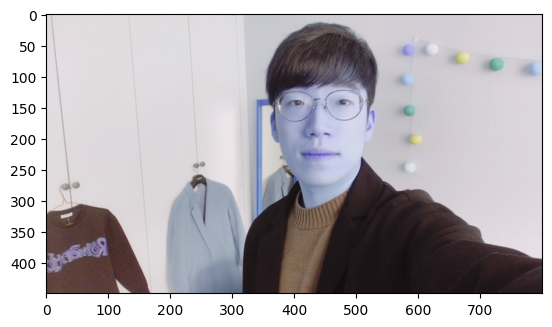

In [2]:
# 준비한 이미지 읽기
# 노드 기준 파일 경로
# my_image_path = 'aiffel/camera_sticker/images/image.png'
# 로컬 기준 파일 경로
my_image_path = '../data/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path) # OpenCV로 이미지 불러옴
img_show = img_bgr.copy()   # 출력용 이미지 따로 보관
plt.imshow(img_bgr) # 이미지 로드 (보여주기) 위해 이미지를 buffer stream으로 저장
plt.show()  # 이미지 출력


## 얼굴 색에 왜 푸른빛이 돌까?
```text
- OpenCV 특징
- matplotlib, dlib의 이미지 채널은 RGB 순서
- opencv의 채널은 BGR 순서
```
결론은 opencv에서 이미지를 다룬 후 다른 이미지 라이브러리에서 활용하여면 색보정이 필요함

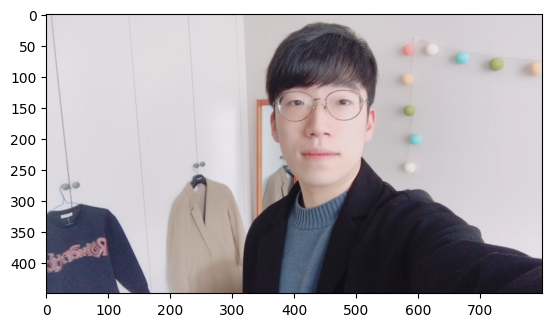

In [3]:
# opencv 이미지를 matplotlib, dlib에서 동일하게 사용가능하도록 채널 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 얼굴 검출 face detetion
## dlib의 face detector는 다음 방식을 사용해서 얼굴을 찾는다.
- HOG (Histogram of Oriented Gradients)
    - 이미지에서 색상의 변화량을 나타낸 것
- SVM (Support Vector Machine)
    - 선형 분류기

In [5]:
# dlib 활용하여 hog detector 선언
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기 반환

# detector_hog를 사용하여 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

# Image Pyramids
[참고링크는 요기](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)</br>

```text
** upsampling?

    - 데이터의 크기를 키우는 것
    - downsampling의 반대 의미
```

rectangles[[(345, 98) (531, 284)]]


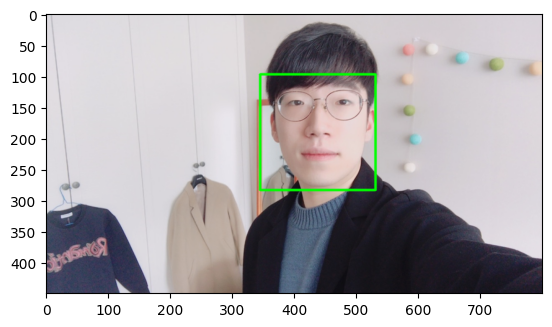

In [9]:
# 찾은 얼굴 화면에 출력
# 이미지에 따라 여러 얼굴이 있을 수 있음
print(dlib_rects)

for dlib_rect in dlib_rects:
    # 왼쪽
    l = dlib_rect.left()
    # 위쪽
    t = dlib_rect.top()
    # 오른쪽
    r = dlib_rect.right()
    # 아래쪽
    b = dlib_rect.bottom()

    # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
    cv2.rectangle(img_show, (l,t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

```text
dlib detector는 `dlib_rectangles` 타입의 객체 반환
`dlib_rectangles`는 `dlib.rectangle` 객체의 배열 형태로 이루어져 있다.
```

자세한 정보 [LINK](https://dlib.net/python/index.html#dlib.rectangles)

## face landmark localization
얼굴을 찾을 때 이목구비의 위치를 추론하는 기술</br>

face landmark는 detection 결과물인 bounding box로 잘라낸(cropped) 얼굴 이미지를 이용함

## Object keypoint estimation 알고리즘
객체(얼굴) 내부의 점을 찾는 기술</br>

1. top-down: bounding box를 찾고 box 내부의 keypoint를 예측
2. bottom-up: 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화(clustering) 해서 box 생성

> 예제에서는 1번 방식을 사용함

## Dlib에서 제공되는 모델 예시
공개되어있는 weight file을 다운로드 받음, 노드 기준 예시
```shell
wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_preditor_68_face_landmarks.dat.bz2
```

> 로컬 기준 `~/data/camera_sticker/models`에 받아둠

In [10]:
# 저장한 landmark 모델 불러오기

# 노드 기준 path
# model_path = 'aiffel/camera_sitcker/models/shape_predictor_68_face_landmarks.dat'
# 로컬 기준 path
model_path = '../data/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

landmark_predictor = dlib.shape_predictor(model_path)
    # landmark_predictor는 RGB 이미지와 dlib.rectangle을 입력 받고 dlib.full_object_detection를 반환
    ## dlib.rectangle --> 내부를 예측하는 박스
    ## dlib.full_object_detection --> 각 구성 요소의 위치와, 이미지 상의 객체 위치를 나타냄

print("모델 불러와쓰")

모델 불러와쓰


In [11]:
# Do it next
# 랜드마크 위치 저장할 list
list_landmarks = []

# 얼굴 영역 박스마다 face landmark 찾기
for dlib_rect in dlib_rects:
    # 모든 landmark 위치 정보를 points에 저장
    points = landmark_predictor(img_rgb, dlib_rect)
    # 각 landmark 위치정보를 (x, y) 형태로 변환해 list_points 리스트에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # list_landmarks에 랜드마크 리스트를 저장
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 가짐
    # 각 원소는 68개의 랜드마크 위치를 가지는 list
    # list_landmarks의 원소가 1개; 그래서 [0] 인덱스를 호출하였음

68


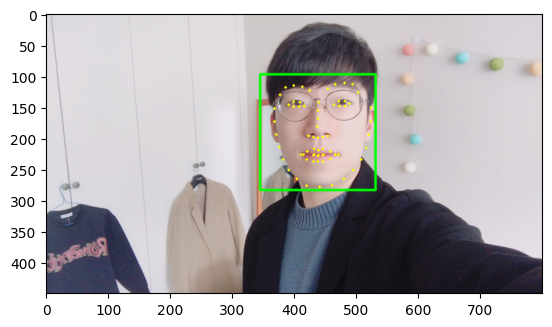

In [12]:
# 랜드마크 영상으로 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle --> 원을 그리는 함수
            # 각 점을 원으로 그리면서
            # 크기는 2, (0, 255, 255) 색깔, 내부가 채워진 (-1) 원으로 그림
            # 마지막 값이 0 보다 큰 자연수면 그 두께만큼의 선이 적용된 원이 그려짐

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_RGB2BGR)
plt.imshow(img_show_rgb)
plt.show()

# 스티커 적용하기
왕관 스티커를 머리에 씌우기</br>
랜드마크를 기준으로 `눈썹 위 얼굴 중앙`에 스티커 씌우는 예제</br>

> 얼굴 위치 및 카메라 거리/해상도에 따라 이미지 픽셀이 다르니까 비율로 계산해야 한다.</br>

1. 스티커 위치
    $$ x = x_{nose} $$
    $$ y = y_{nose} - height / 2 $$
2. 스티커 크기
    $$ width = height = widht_{bbox} $$


In [13]:
# 좌표를 확인해보자

# dlib_rects: 얼굴 영역을 저장하고 있는 값
# list_landmarks: 모델의 라벨링 데이터 (68개 랜드마크 값)
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # 코의 index는 30
    print(landmark[30])
    # 이미지에서 코 부위의 x값
    x = landmark[30][0]
    # 이미지에서 코 부위의 y값; 얼굴 영역의 세로를 차지하는 픽셀의 수
    y = landmark[30][1] - dlib_rect.height() // 2
    # 얼굴 영역의 가로를 차지하는 픽셀의 수
    w = h = dlib_rect.width()

    print(f"(x, y) : ({x}, {y})")
    print(f"(w, h) : ({w}, {h})")
    

(437, 182)
(x, y) : (437, 89)
(w, h) : (187, 187)


In [15]:
# 스티커 이미지 읽어서 왕관 씌워보기
# 스티커 경로; 노드 기준 예시
# sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
# 로컬 기준 예시
sticker_path = '../data/camera_sticker/images/king.png'
# 스티커 이미지 로드
img_sticker = cv2.imread(sticker_path)
# 스티커 이미지 사이즈 조정
img_sticker = cv2.resize(img_sticker, (w, h))
# resizing된 이미지의 차원 확인
print(img_sticker.shape)

(187, 187, 3)


In [16]:
# 원본 이미지에 스티커 이미지 추가하기
# x, y, w, h 는 모두 위 반복문에서 지정됨
# refind_x, refind_y 부터 왕관 이미지가 그려짐
refind_x = x - w // 2
refind_y = y - h

# 값 확인
print(f"(x, y) : ({refind_x}, {refind_y})")

## opencv는 ndarray를 사용하고, 음수인덱스에 접근 불가
## 스티커 이미지를 잘라야함

(x, y) : (344, -98)


In [17]:
# 이미지 범위 벗어난 값 조정하기
# 좌표 순서는 (y, x, rgb-channel)
if refind_x < 0:
    img_sticker = img_sticker[:, -refind_x:]
    refind_x = 0

if refind_y < 0:
    img_sticker = img_sticker[-refind_y:, :]
    refind_y = 0

# 조정된 좌표값 확인
print(f"(x, y) : ({refind_x}, {refind_y})")

(x, y) : (344, 0)


In [20]:
# 원본 이미지에 스티커 적용하기
sticker_area = img_show[refind_y:refind_y+img_sticker.shape[0], refind_x:refind_x+img_sticker.shape[1]]

img_show[refind_y:refind_y+img_sticker.shape[0], refind_x:refind_x+img_sticker.shape[1]] = np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
print("적요옹")

적요옹


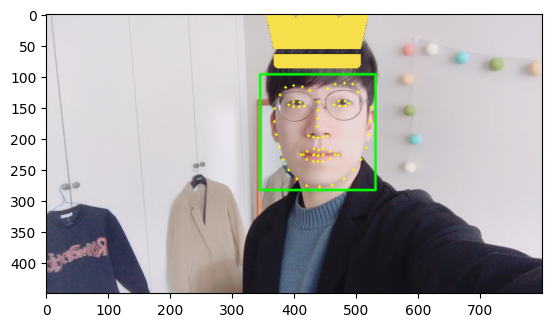

In [22]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

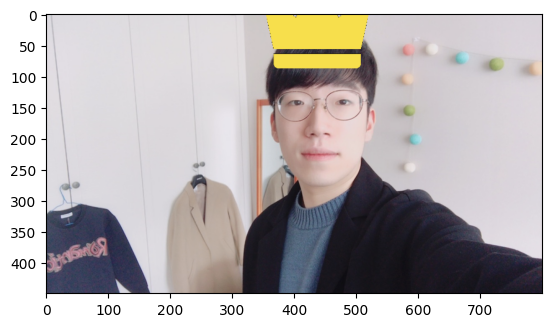

In [23]:
# bounding 박스와 landmark 제거하고 최종 결과 출력
# 왕관 이미지
sticker_area = img_bgr[refind_y:refind_y+img_sticker.shape[0], refind_x:refind_x+img_sticker.shape[1]]

# img_bgr은 원본 이미지
img_bgr[refind_y:refind_y+img_sticker.shape[0], refind_x:refind_x+img_sticker.shape[1]] = np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
# 원본이미지 + 왕관 이미지
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()